#**Building a Neural Network in Pytorch**

In this notebook, we’ll build a simple feed-forward neural network in **PyTorch** to classify the MNIST dataset of handwritten digits (0-9). We’ll cover:
1. Importing and setting up PyTorch.  
2. Preparing MNIST data (using PyTorch datasets and dataloaders).  
3. Defining a multi-layer perceptron (MLP) for digit classification.  
4. Choosing a loss function (CrossEntropy) and an optimizer (Adam).  
5. Training for multiple epochs and visualizing performance (loss, accuracy, and predictions).
6. (Optional) Experimenting with an improved architecture using batch normalization, dropout, etc.

By the end, you’ll have a working PyTorch model that can recognize handwritten digits, and you’ll be equipped to extend it for other classification tasks.


---
##📚 **Library Overview**

- **PyTorch** ([Documentation](https://pytorch.org/docs/stable/)):  
  - **`torch`** for tensors and mathematical operations,  
  - **`torch.nn`** for neural network layers,  
  - **`torch.optim`** for optimization algorithms,  
  - **`torch.utils.data`** for data loading and batching.

- **TorchVision** ([Documentation](https://pytorch.org/vision/stable/)):  
  - Provides common datasets (MNIST, CIFAR, etc.) and image transformations.

- **Matplotlib** ([Documentation](https://matplotlib.org/)):  
  - Used here to plot training/testing metrics and visualize sample predictions.

All random processes can leverage GPU acceleration if available (`torch.cuda.is_available()`).


### **Imports**


In [1]:
# PyTorch Deep Neural Network Tutorial for Complete Beginners
# ==========================================================
# This script walks through building a neural network from scratch using PyTorch.
# We'll create a simple feed-forward neural network to classify the MNIST dataset
# (handwritten digits from 0-9).

# Step 1: Import necessary libraries
# ----------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


### **CUDA Setup**


In [2]:
# Step 2: Set up CUDA (GPU) if available
# -------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### **Data Preparation**


In [3]:
# Step 3: Prepare the data
# -----------------------
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST
])

# Download and load the training data
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

# Create data loaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check dataset details
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Each image shape: {train_dataset[0][0].shape}")  # [channels, height, width]
print(f"Number of classes: {len(train_dataset.classes)}")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.79MB/s]

Training dataset size: 60000
Test dataset size: 10000
Each image shape: torch.Size([1, 28, 28])
Number of classes: 10


**Explanation:**

1. **Transforms**:
   - **`transforms.ToTensor()`**: Converts the PIL Image from [0, 255] to a normalized [0.0, 1.0] tensor.  
   - **`transforms.Normalize(...)`**: Normalizes the tensor with mean and standard deviation of the MNIST dataset.

2. **Dataset and DataLoaders**:
   - **`train_dataset`** / **`test_dataset`**: PyTorch automatically downloads the MNIST dataset if not already present.  
   - **`train_loader`** / **`test_loader`**: Used for batch processing. Set **`batch_size = 64`** and **`shuffle=True`** for the training set.

3. **Dataset Inspection**:
   - **`len(train_dataset)`**: Number of training examples.  
   - **`train_dataset[0][0].shape`**: Shape of a single MNIST image (1×28×28).  
   - **`train_dataset.classes`**: Contains the different classes (digits 0–9).


### **Defining the Neural Network**


In [4]:
# Step 4: Define the neural network architecture
# --------------------------------------------
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Input layer: 28x28 images flattened to 784 inputs
        # First hidden layer: 784 -> 128 neurons
        self.fc1 = nn.Linear(28*28, 128)

        # Second hidden layer: 128 -> 64 neurons
        self.fc2 = nn.Linear(128, 64)

        # Output layer: 64 -> 10 neurons (one for each digit class)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten the input image from (batch_size, 1, 28, 28) to (batch_size, 784)
        x = x.view(-1, 28*28)

        # Pass through hidden layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (logits, softmax to be applied later)
        x = self.fc3(x)
        return x

# Create an instance of our model and move it to the device (CPU/GPU)
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


**Explanation:**

- **`NeuralNetwork(nn.Module)`**:
  1. **`__init__`**: Creates linear layers.
     - **`fc1`**: Input dimension = 784 (28×28 pixels), output dimension = 128  
     - **`fc2`**: Input dimension = 128, output dimension = 64  
     - **`fc3`**: Input dimension = 64, output dimension = 10 (digit classes)
  2. **`forward`**: Defines the forward pass through ReLU-activated hidden layers and outputs **logits** (raw scores).

- **`.to(device)`**: Transfers the model’s parameters to the chosen device (CPU or GPU).


### **Loss Function & Optimizer**


In [5]:
# Step 5: Define the loss function and optimizer
# --------------------------------------------
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Explanation:**

- **`nn.CrossEntropyLoss()`**:  
  - Common choice for multi-class classification.  
  - Combines **LogSoftmax** and **NLLLoss** in one single function.

- **`optim.Adam(...)`**:  
  - A popular adaptive learning rate optimizer.  
  - **`lr=0.001`** is a typical starting learning rate for Adam.


### **Training and Testing Functions**


In [6]:
# Step 6: Define training and testing functions
# -------------------------------------------
def train(model, device, train_loader, optimizer, loss_function, epoch):
    model.train()  # Set model to training mode
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()           # Clear gradients
        output = model(data)           # Forward pass
        loss = loss_function(output, target)  # Compute loss
        loss.backward()                # Backprop
        optimizer.step()               # Update parameters

        total_loss += loss.item()

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    return total_loss / len(train_loader)

def test(model, device, test_loader, loss_function):
    model.eval()  # Evaluation mode disables dropout/batchnorm updates
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()
            pred = output.argmax(dim=1)  # Predictions
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.1f}%)\n')

    return test_loss, accuracy


**Explanation:**

- **`train(...)`**:
  1. **`model.train()`**: Sets layers like dropout/batchnorm to “training” mode.  
  2. Iterates over **`train_loader`** in batches:
     - **`optimizer.zero_grad()`** to clear previous gradients.  
     - **Forward pass** -> **`loss.backward()`** -> **`optimizer.step()`**.  
  3. Prints loss every 100 batches for progress monitoring.

- **`test(...)`**:
  1. **`model.eval()`**: Disables certain training behaviors (dropout, etc.).  
  2. Iterates over **`test_loader`**, computing **average test loss** and **accuracy**.
  3. Uses **`torch.no_grad()`** to skip gradient computations during inference (saves memory & compute).


### **Model Training**


In [7]:
# Step 7: Train the model
# ----------------------
num_epochs = 5
train_losses = []
test_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, loss_function, epoch)
    train_losses.append(train_loss)

    test_loss, accuracy = test(model, device, test_loader, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

print("Training complete!")


Starting training...
Epoch: 1 [0/60000 (0%)]	Loss: 2.326310
Epoch: 1 [6400/60000 (11%)]	Loss: 0.332969
Epoch: 1 [12800/60000 (21%)]	Loss: 0.201835
Epoch: 1 [19200/60000 (32%)]	Loss: 0.234716
Epoch: 1 [25600/60000 (43%)]	Loss: 0.189634
Epoch: 1 [32000/60000 (53%)]	Loss: 0.078471
Epoch: 1 [38400/60000 (64%)]	Loss: 0.243077
Epoch: 1 [44800/60000 (75%)]	Loss: 0.111979
Epoch: 1 [51200/60000 (85%)]	Loss: 0.230043
Epoch: 1 [57600/60000 (96%)]	Loss: 0.232046

Test set: Average loss: 0.1526, Accuracy: 9528/10000 (95.3%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.100345
Epoch: 2 [6400/60000 (11%)]	Loss: 0.108123
Epoch: 2 [12800/60000 (21%)]	Loss: 0.197412
Epoch: 2 [19200/60000 (32%)]	Loss: 0.149267
Epoch: 2 [25600/60000 (43%)]	Loss: 0.076286
Epoch: 2 [32000/60000 (53%)]	Loss: 0.062835
Epoch: 2 [38400/60000 (64%)]	Loss: 0.032385
Epoch: 2 [44800/60000 (75%)]	Loss: 0.207260
Epoch: 2 [51200/60000 (85%)]	Loss: 0.091564
Epoch: 2 [57600/60000 (96%)]	Loss: 0.111949

Test set: Average loss: 0.1117, Accuracy: 9648/

**Explanation:**
- We train for **5 epochs**.  
- Each epoch:
  1. Calls **`train(...)`** and records the average **training loss**.  
  2. Calls **`test(...)`** and records the **test loss** & **accuracy**.  
- Results are appended to lists for later visualization (`train_losses`, `test_losses`, `test_accuracies`).


### **Visualizing Training & Testing**


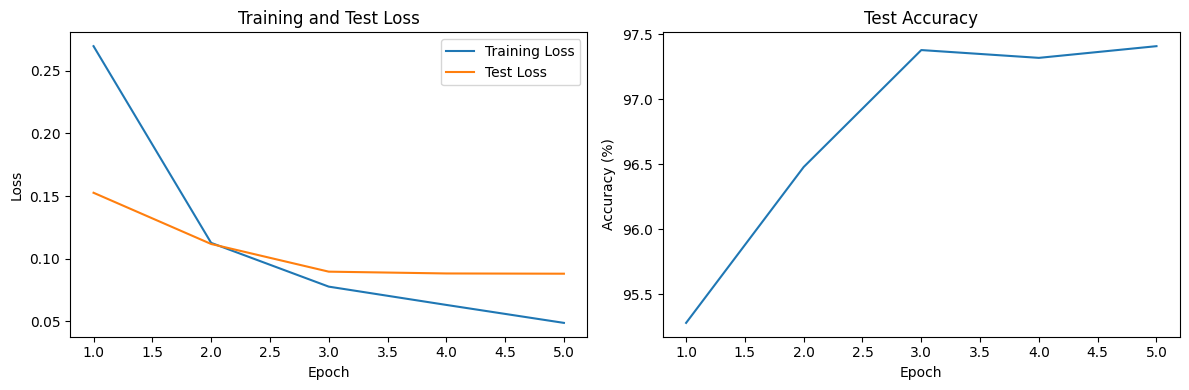

In [8]:
# Step 8: Visualize the results
# ---------------------------
plt.figure(figsize=(12, 4))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()


**Explanation:**

- **Training vs. Test Loss**:  
  - Helps identify overfitting if training loss continues decreasing while test loss goes up.  
- **Test Accuracy**:  
  - Generally should rise with each epoch if the model is learning effectively.


### **Saving the Model**


In [9]:
# Step 9: Save the trained model
# ----------------------------
torch.save(model.state_dict(), 'mnist_model.pth')
print("Model saved to 'mnist_model.pth'")


Model saved to 'mnist_model.pth'


**Explanation:**

- **`torch.save(model.state_dict(), 'mnist_model.pth')`**:  
  - Saves the model’s learned parameters (weights).  
  - **`model.state_dict()`** is a Python dictionary with all the parameter tensors.
- To restore later, you’d do:  
  ```python
  model.load_state_dict(torch.load('mnist_model.pth'))


### **Visualizing Predictions**


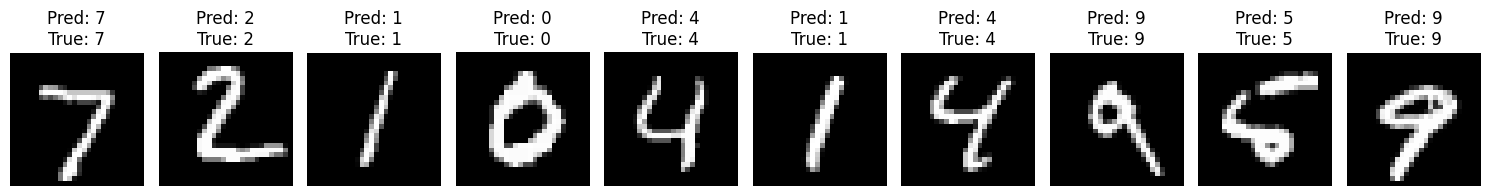

In [10]:
# Step 10: Visualize some predictions
# ---------------------------------
def visualize_predictions(model, device, test_loader, num_samples=10):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Move to device and make predictions
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot the first num_samples test images
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, device, test_loader)


**Explanation:**

1. **`visualize_predictions`**:
   - Grabs a batch from the **test_loader**.  
   - Moves it to the same **device** as the model.  
   - Calls **`model(...)`** to get predictions.  
   - Displays **10** images side by side, with the **predicted** and **actual** labels.


### **Bonus: Experimenting with the Model**


ImprovedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch: 1 [0/60000 (0%)]	Loss: 2.298069
Epoch: 1 [6400/60000 (11%)]	Loss: 0.351820
Epoch: 1 [12800/60000 (21%)]	Loss: 0.294642
Epoch: 1 [19200/60000 (32%)]	Loss: 0.386032
Epoch: 1 [25600/60000 (43%)]	Loss: 0.448039
Epoch: 1 [32000/60000 (53%)]	Loss: 0.206175
Epoch: 1 [38400/60000 (64%)]	Loss: 0.340232
Epoch: 1 [44800/60000 (75%)]	Loss: 0.088279
Epoch: 1 [51200/60000 (85%)]	Loss: 0.369010
Epoch: 1 [57600/60000 (96%)]

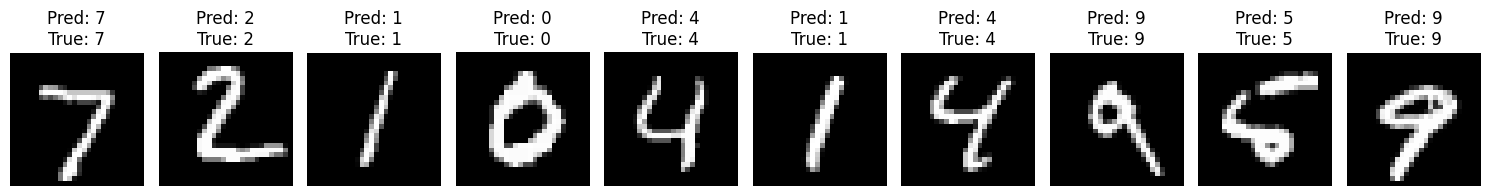

In [11]:
# Bonus: Experimenting with the model
# ----------------------------------
# Example of a more complex model with improvements
class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ImprovedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28*28)

        # First layer with ReLU, batchnorm, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third layer
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.fc4(x)
        return x

# Uncomment and run to train the improved model
improved_model = ImprovedNeuralNetwork().to(device)
print(improved_model)

# Use a different optimizer with learning rate scheduling
improved_optimizer = optim.SGD(improved_model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(improved_optimizer, step_size=1, gamma=0.7)

# Train for more epochs
num_epochs = 10
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(improved_model, device, train_loader, improved_optimizer, loss_function, epoch)
    train_losses.append(train_loss)

    test_loss, accuracy = test(improved_model, device, test_loader, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    # Update learning rate
    scheduler.step()

# Save the improved model
torch.save(improved_model.state_dict(), 'improved_mnist_model.pth')
print("Improved model saved to 'improved_mnist_model.pth'")

# Visualize predictions from the improved model
visualize_predictions(improved_model, device, test_loader)


**Explanation:**

- **`ImprovedNeuralNetwork`**:
  - **Batch Normalization** on each layer (e.g., `nn.BatchNorm1d(...)`).  
  - **Dropout** to reduce overfitting.  
- **Different Optimizer**:  
  - **`SGD`** with momentum, plus a **learning rate scheduler** (StepLR).  
- **More epochs** and saving to **`improved_mnist_model.pth`** for better performance.

Feel free to customize:
- Layer sizes  
- Dropout rates  
- Activation functions  
- Number of epochs  
- Optimizer parameters  
- And so on!


## 📚**Additional Reading & Resources**

- **PyTorch Official Tutorials**:  
  [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)  
  Comprehensive guides for both basic and advanced PyTorch topics.

- **MNIST**:  
  [LeCun’s MNIST Page](http://yann.lecun.com/exdb/mnist/)  
  Historical context and details of the dataset.

- **Kaggle Notebooks**:  
  - [Basic MNIST PyTorch Example](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)  
  - [MNIST Classification with PyTorch & Lightning](https://www.kaggle.com/code/fold10/mnist-image-classification-with-pytorch-lightning?utm_source=chatgpt.com)

- **Deep Learning Concepts**:  
  - [Deep Learning Book (Goodfellow et al.)](https://www.deeplearningbook.org/)  
  - [fast.ai Course](https://www.fast.ai/) for practical deep learning.


## **Optional / Advanced Ideas**

1. **Data Augmentation**:  
   - Apply random transformations (rotation, flipping, shifting) to increase robustness.

2. **Hyperparameter Tuning**:  
   - Try different batch sizes, learning rates, or optimizers like SGD, RMSProp, or AdamW.

3. **Model Architectures**:  
   - Experiment with Convolutional Neural Networks (CNNs) to improve performance on image data.

4. **Early Stopping**:  
   - Stop training once the test loss stops improving to avoid overfitting.

5. **Learning Rate Schedules**:  
   - Cosine Annealing, Exponential decay, or Cyclical LR can sometimes improve training speed and final accuracy.
